In [19]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive

drive.mount('/content/drive/')
base_directory = "/content/drive/MyDrive/meta-2024-Nov-25-11-52-50"
instagram_file_path = f'{base_directory}/instagram-gercekten.idil-2024-11-25-xmCJFTlJ/your_instagram_activity/likes/liked_posts.json'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


liked_posts.json has the following structure and only the timestamp data is needed. Therefore, the nested structure is flatten to title and timestamp in the following part:

 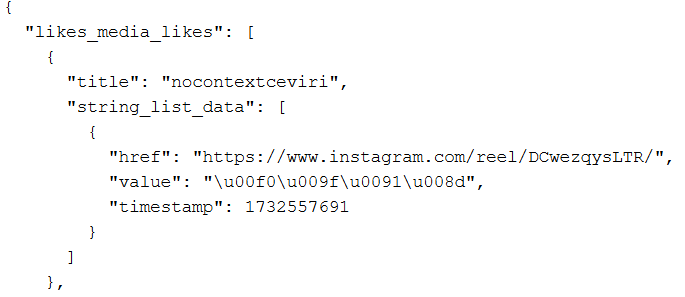

In [20]:
# Read the JSON file with my Instagram activity
with open(instagram_file_path, 'r') as file:
    data = json.load(file)

# Use json_normalize to flatten the nested structure
# Specify the paths to extract the data needed
df = pd.json_normalize(
    data['likes_media_likes'],
    record_path='string_list_data',
    meta=['title'],
    errors='ignore'
)[['title', 'timestamp']]

# Convert timestamp to datetime for better readability
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Display the first few rows
print(df.head())

               title           timestamp
0    nocontextceviri 2024-11-25 18:01:31
1     gatitos_ultras 2024-11-25 17:26:40
2             admbrs 2024-11-25 17:25:50
3         gibiyoloji 2024-11-25 17:25:31
4  askokuskoyuzbeybi 2024-11-25 17:04:59


In [21]:
# Define a function to separate data into 4 distinct periods of my life
def assign_custom_period(timestamp):
    if pd.Timestamp('2018-12-16') <= timestamp < pd.Timestamp('2020-06-20'):
        return '1. University'
    elif pd.Timestamp('2020-10-05') <= timestamp < pd.Timestamp('2022-09-30'):
        return 'Full-time Work'
    elif pd.Timestamp('2022-10-01') <= timestamp < pd.Timestamp('2023-06-18'):
        return 'Exam Preperation'
    elif pd.Timestamp('2023-10-02') <= timestamp <= pd.Timestamp('2024-11-26'):
        return '2. University'
    else:
        return 'Undefined Period'

df['custom_period'] = df['timestamp'].apply(assign_custom_period)
df = df[df['custom_period'] != 'Undefined Period']
df

,title,timestamp,custom_period
0,nocontextceviri,2024-11-25 18:01:31,2. University
1,gatitos_ultras,2024-11-25 17:26:40,2. University
2,admbrs,2024-11-25 17:25:50,2. University
3,gibiyoloji,2024-11-25 17:25:31,2. University
4,askokuskoyuzbeybi,2024-11-25 17:04:59,2. University
...,...,...,...
33049,niluferbs,2018-12-17 08:54:09,1. University
33050,brooklyn99,2018-12-17 08:53:06,1. University
33051,comics,2018-12-16 23:04:14,1. University
33052,marvelograf,2018-12-16 19:33:47,1. University


In [23]:
# Analyze daily likes from Instagram data including days with zero activity
def analyze_daily_likes(df, date_column='timestamp', group_column='custom_period'):
    df_copy = df.copy()
    df_copy['date'] = pd.to_datetime(df[date_column]).dt.date

    # Get initial daily counts
    daily_counts = df_copy.groupby([group_column, 'date']).size().reset_index(name='count')

    # Initialize list to store complete data for each period
    complete_data = []

    # Process each period separately
    for period in daily_counts[group_column].unique():
        # Filter data for current period
        period_data = daily_counts[daily_counts[group_column] == period]

        # Create complete date range for this period
        date_range = pd.date_range(
            start=pd.to_datetime(period_data['date'].min()),
            end=pd.to_datetime(period_data['date'].max()),
            freq='D'
        ).date  # Convert to date objects

        # Create template DataFrame with all dates
        template = pd.DataFrame({
            'date': date_range,
            group_column: period
        })

        # Merge with actual counts
        merged = pd.merge(
            template,
            period_data,
            on=['date', group_column],
            how='left'
        )

        # Fill missing values with 0
        merged['count'] = merged['count'].fillna(0)
        complete_data.append(merged)

    # Combine all periods
    complete_daily_counts = pd.concat(complete_data, ignore_index=True)

    # Sort by period and date
    complete_daily_counts = complete_daily_counts.sort_values([group_column, 'date'])

    # Calculate summary statistics
    summary_stats = complete_daily_counts.groupby(group_column).agg({
        'count': ['mean', 'median', 'min', 'max', 'sum', 'std'],
        'date': ['min', 'max', 'count']
    }).round(2)

    return complete_daily_counts, summary_stats

complete_counts, summary = analyze_daily_likes(df)

# Display sample of complete daily counts
print("Sample of complete daily counts (including zero-activity days):")
print(complete_counts.head(10))

print("\nSummary statistics by period:")
print(summary)

Sample of complete daily counts (including zero-activity days):
         date  custom_period  count
0  2018-12-16  1. University    3.0
1  2018-12-17  1. University   12.0
2  2018-12-18  1. University    4.0
3  2018-12-19  1. University    9.0
4  2018-12-20  1. University    7.0
5  2018-12-21  1. University   11.0
6  2018-12-22  1. University   13.0
7  2018-12-23  1. University    3.0
8  2018-12-24  1. University    5.0
9  2018-12-25  1. University    6.0

Summary statistics by period:
                  count                                           date  \
                   mean median  min    max      sum    std         min   
custom_period                                                            
1. University     10.30    9.0  0.0   94.0   5686.0  10.82  2018-12-16   
2. University     17.52   14.0  0.0   92.0   7374.0  15.19  2023-10-02   
Exam Preperation  12.28    9.0  0.0   94.0   3192.0  11.91  2022-10-01   
Full-time Work    17.67   14.0  0.0  101.0  12811.0  17.12  2020-

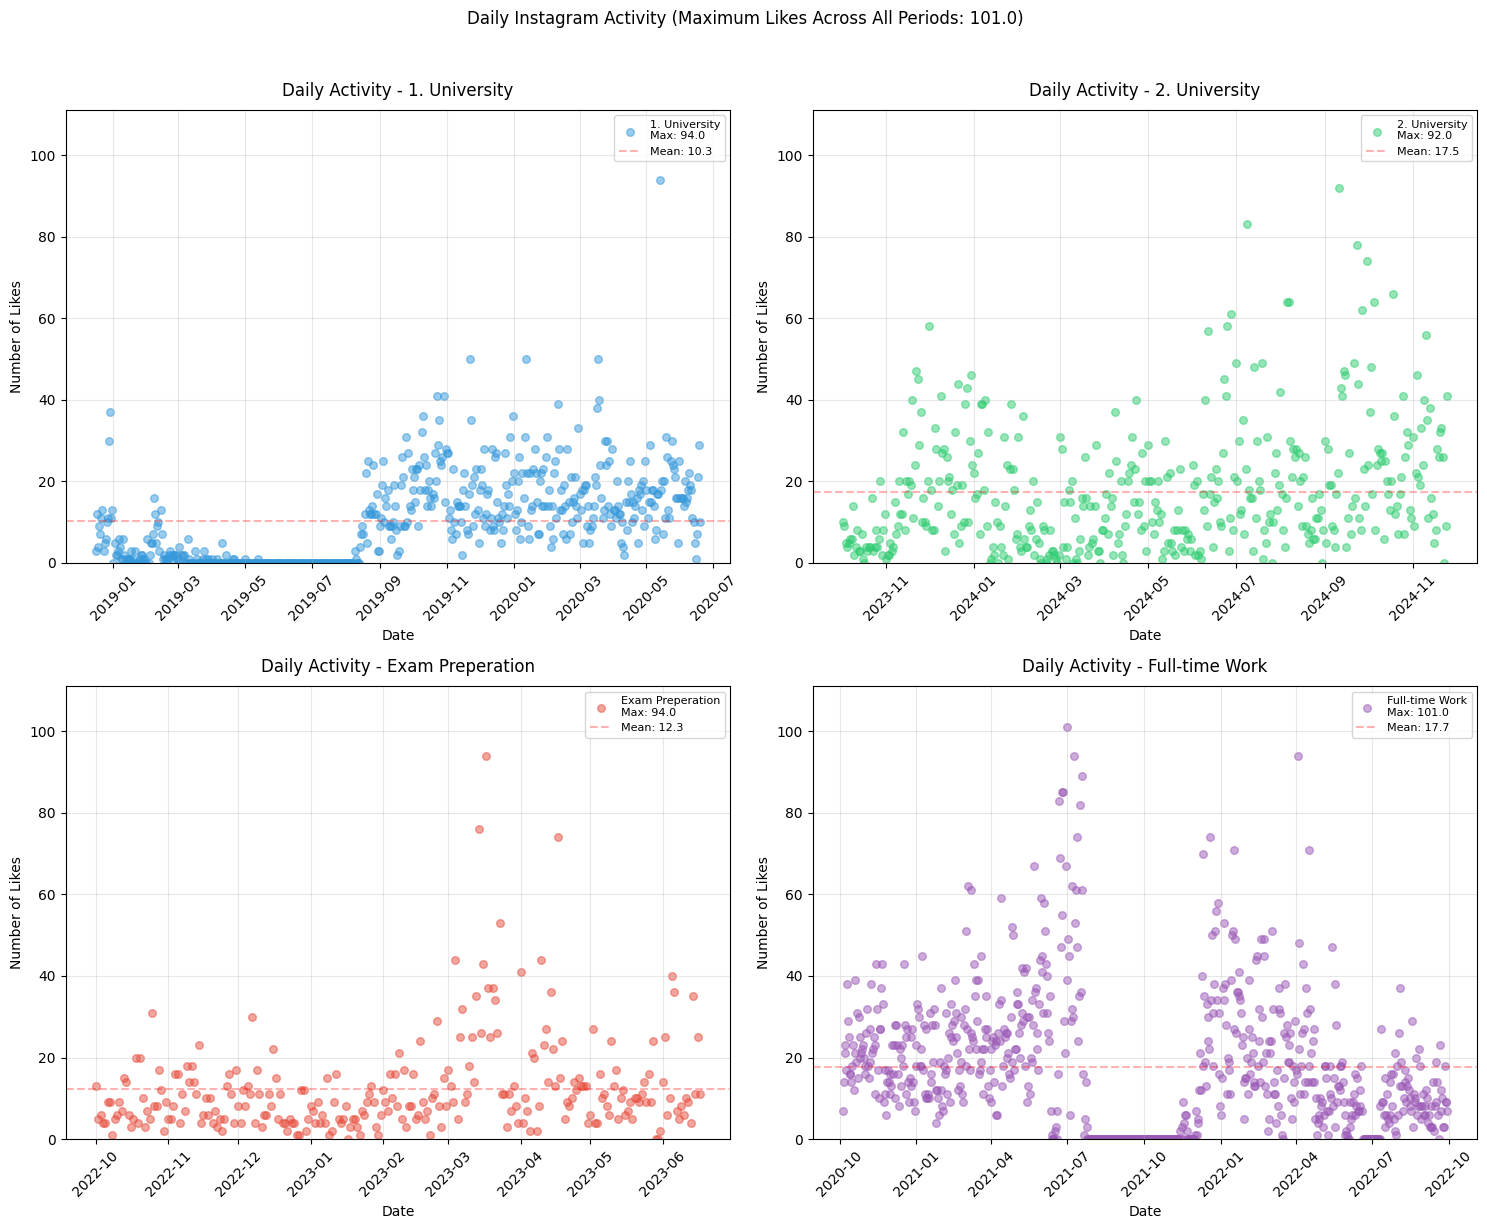


Maximum likes by period:
1. University: 94.0 likes
2. University: 92.0 likes
Exam Preperation: 94.0 likes
Full-time Work: 101.0 likes


In [25]:
# Create scatter plots of daily Instagram activity for each period with standardized y-axis for easy comparison between different periods
def create_activity_plots_standardized(complete_counts):
    plt.style.use('default')

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    max_count = complete_counts['count'].max()

    y_max = max_count * 1.1

    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

    for idx, (period, group) in enumerate(complete_counts.groupby('custom_period')):
        ax = axes[idx]

        ax.scatter(
            group['date'],
            group['count'],
            alpha=0.5,
            s=30,
            c=colors[idx],
            label=f'{period}\nMax: {group["count"].max()}'
        )

        ax.set_ylim(0, y_max)

        ax.set_title(f'Daily Activity - {period}', pad=10)
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Likes')

        ax.tick_params(axis='x', rotation=45)

        ax.grid(True, alpha=0.3)

        mean_likes = group['count'].mean()
        ax.axhline(y=mean_likes, color='red', linestyle='--', alpha=0.3,
                  label=f'Mean: {mean_likes:.1f}')

        ax.legend(fontsize=8, loc='upper right')

    fig.suptitle(f'Daily Instagram Activity (Maximum Likes Across All Periods: {max_count})',
                y=1.02, fontsize=12)

    plt.tight_layout()

    return fig

# Create the visualization
fig = create_activity_plots_standardized(complete_counts)
plt.show()

# Print out the maximum values for each period for reference
print("\nMaximum likes by period:")
for period, group in complete_counts.groupby('custom_period'):
    print(f"{period}: {group['count'].max()} likes")

In [26]:
# Remove sequences of zeros that are outliers where I deliberately did not use Instagram while preserving normal zero-count days
def clean_outlier_sequences(df, window_size=7):
    cleaned_df = df.copy()

    # For each period, identify and remove outlier sequences
    for period in cleaned_df['custom_period'].unique():
        period_mask = cleaned_df['custom_period'] == period
        period_data = cleaned_df[period_mask].copy()

        zero_mask = period_data['count'] == 0
        rolling_zeros = zero_mask.rolling(window=window_size, min_periods=1).sum()

        # Identify dates to remove where window_size is consecutive zeros
        dates_to_remove = period_data[rolling_zeros >= window_size].index

        if len(dates_to_remove) > 0:
            print(f"\nRemoving outlier sequence from {period}:")
            print(f"Removed {len(dates_to_remove)} days")
            print(f"Date range: {period_data.loc[dates_to_remove, 'date'].min()} to {period_data.loc[dates_to_remove, 'date'].max()}")

        # Remove these dates from cleaned DataFrame
        cleaned_df = cleaned_df.drop(dates_to_remove)

    return cleaned_df

cleaned_counts = clean_outlier_sequences(complete_counts)

print("\nBefore cleaning:")
print(complete_counts.groupby('custom_period')['count'].agg(['count', 'mean', 'min', 'max']))

print("\nAfter cleaning:")
print(cleaned_counts.groupby('custom_period')['count'].agg(['count', 'mean', 'min', 'max']))


Removing outlier sequence from 1. University:
Removed 89 days
Date range: 2019-04-28 to 2019-08-08

Removing outlier sequence from Full-time Work:
Removed 123 days
Date range: 2021-07-31 to 2022-07-10

Before cleaning:
                  count       mean  min    max
custom_period                                 
1. University       552  10.300725  0.0   94.0
2. University       421  17.515439  0.0   92.0
Exam Preperation    260  12.276923  0.0   94.0
Full-time Work      725  17.670345  0.0  101.0

After cleaning:
                  count       mean  min    max
custom_period                                 
1. University       463  12.280778  0.0   94.0
2. University       421  17.515439  0.0   92.0
Exam Preperation    260  12.276923  0.0   94.0
Full-time Work      602  21.280731  0.0  101.0


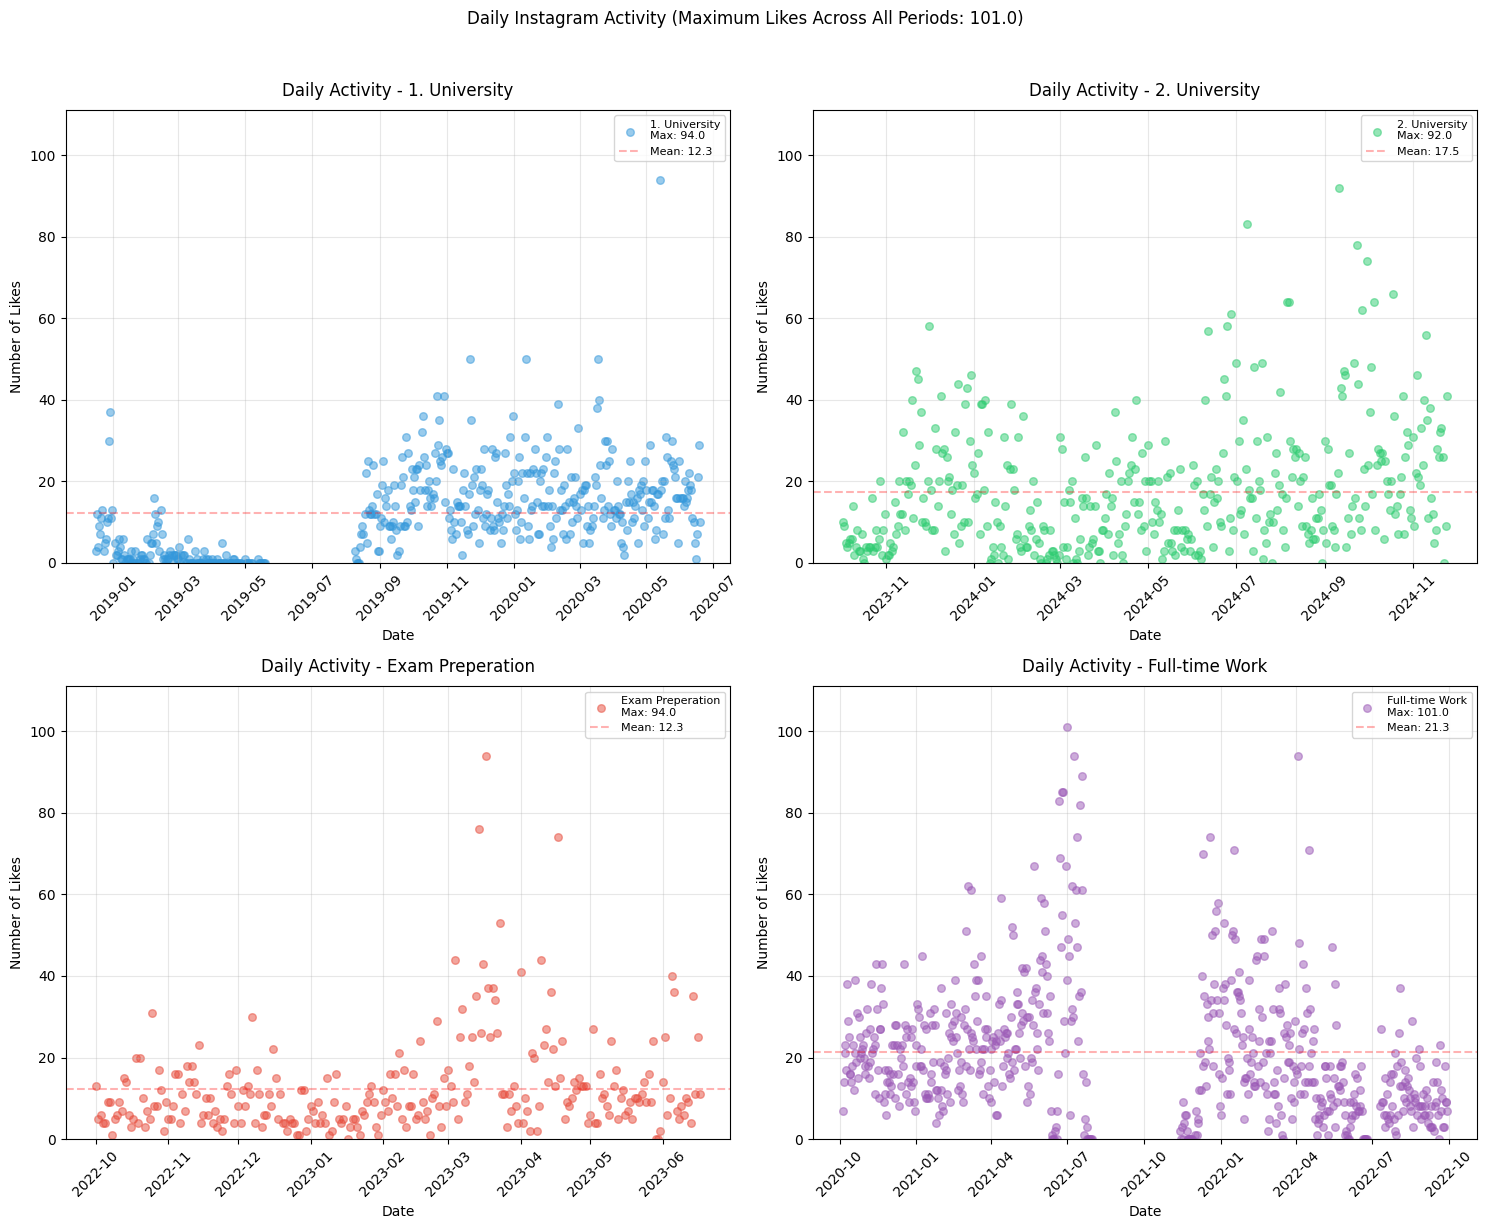


Maximum likes by period:
1. University: 94.0 likes
2. University: 92.0 likes
Exam Preperation: 94.0 likes
Full-time Work: 101.0 likes


In [27]:
# Create the visualization
fig = create_activity_plots_standardized(cleaned_counts)
plt.show()

print("\nMaximum likes by period:")
for period, group in cleaned_counts.groupby('custom_period'):
    print(f"{period}: {group['count'].max()} likes")


Detailed Statistics by Period:
                  count       mean        std  min  25%   50%    75%    max
custom_period                                                              
1. University     463.0  12.280778  10.736866  0.0  3.0  11.0  18.00   94.0
2. University     421.0  17.515439  15.191723  0.0  6.0  14.0  24.00   92.0
Exam Preperation  260.0  12.276923  11.906661  0.0  5.0   9.0  15.00   94.0
Full-time Work    602.0  21.280731  16.613626  0.0  9.0  18.0  28.75  101.0


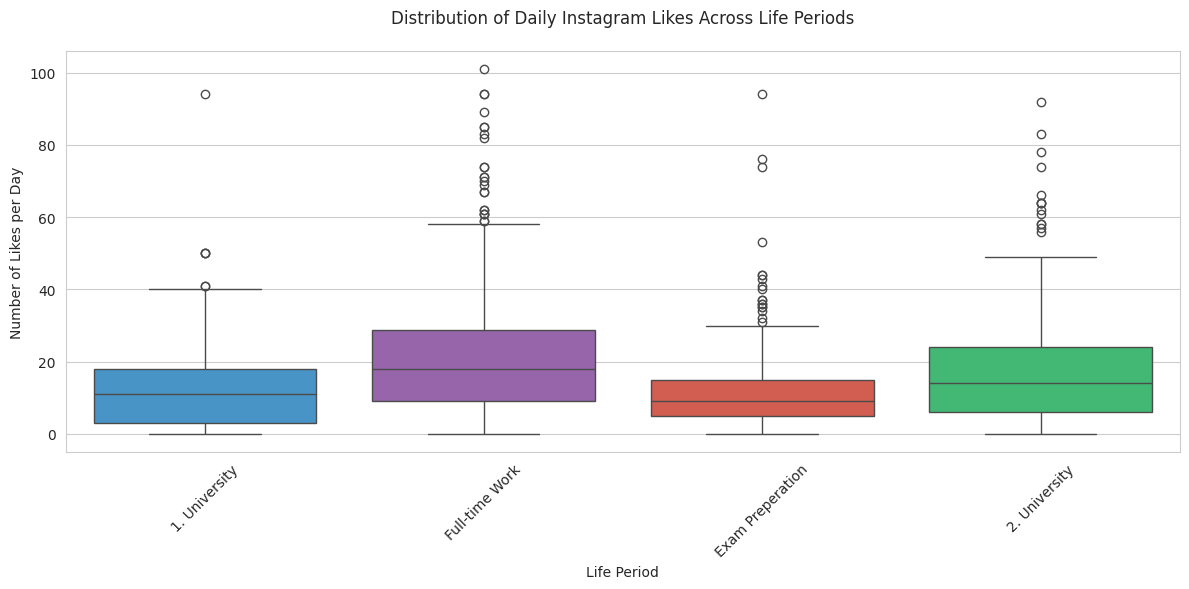

In [28]:
# Create side-by-side boxplots for all periods for comparison
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

box_plot = sns.boxplot(
    data=cleaned_counts,
    x='custom_period',
    y='count',
    hue='custom_period',
    order=['1. University', 'Full-time Work', 'Exam Preperation', '2. University'],
    palette=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'],
    legend=False
)

plt.title('Distribution of Daily Instagram Likes Across Life Periods', pad=20)
plt.xlabel('Life Period')
plt.ylabel('Number of Likes per Day')

plt.xticks(rotation=45)

plt.tight_layout()

print("\nDetailed Statistics by Period:")
stats_summary = cleaned_counts.groupby('custom_period')['count'].describe()
print(stats_summary)

plt.show()